In [1]:
import sys
import os
from tqdm import tqdm

import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [2]:
print("PyTorch version: ", torch.__version__)
print("GPU Detected:" ,torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0))

#defining a shortcut function for later:
# import os
# using_GPU = os.path.exists('/opt/bin/nvidia-smi')

using_GPU = torch.cuda.is_available()


PyTorch version:  1.9.0+cu102
GPU Detected: True
GPU Device Name: NVIDIA GeForce MX150


In [3]:
dataFolderPath = os.path.join("data2_1")

In [4]:
trainingPercentage = 0.7
testPercentage = 0.3

In [5]:
folders = ["data2_1", "data2_2", "data2_3"]
csvLists = [glob.glob(f"{folder}/*.csv") for folder in folders]

In [6]:
# print(csvLists)

In [7]:
overallTrain = []
overallTest = []
for csvList in csvLists:  
  train, test = train_test_split(csvList,
                                test_size=testPercentage,
                                train_size=trainingPercentage)
  overallTrain.extend(train)
  overallTest.extend(test)

## Define and fine tune the pre-process function
Our dataset contains many columns we don't need

In [8]:
def preProcessDataFrame(df: pd.DataFrame) -> pd.DataFrame:
  """
  Takes in a dataframe and returns another dataframe that contains only the data we want.
  Might wanna normalise the data as well
  Maybe fill the nulls with zeros or other appropriate values.
  """
  df_cp = df.copy()
  
#   df_cp.dropna(axis=0,
#                how='any', 
#                subset=["username", "tweet id"], 
#                inplace=True)
  
  df_cp = df_cp[["#followers",
                "#friends",
                "#retweets",
                "#favorites",
                "weekend",
                "entity_count",
                "hashtag_count",
                "mention_count",
                "url_count",
                "tlen",
                "ratio_fav_#followers",
                "time_importance",
                "sentiment_ppn",
                "sine_hour",
                "cosine_hour",
                "sine_day",
                "cosine_day",
                "sine_day_of_week",
                "cosine_day_of_week"
                ]]
  return df_cp


# sampleDf = pd.read_csv(overallTrain[0])
sampleDf = pd.read_csv(f"{dataFolderPath}/covid_data_1.csv")
# print(sampleDf.head())
print(sampleDf.info())
# [print(x) for x in sampleDf.columns] # show list of columns in sampleDf
print("\n====[AFTER PRE-PROCESSING]====\n")
# print(preProcessDataFrame(sampleDf.head()))
pp = preProcessDataFrame(sampleDf)
print(pp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            10000 non-null  int64  
 1   tweet_id              10000 non-null  int64  
 2   username              10000 non-null  object 
 3   timestamp             10000 non-null  object 
 4   #followers            10000 non-null  float64
 5   #friends              10000 non-null  int64  
 6   #retweets             10000 non-null  int64  
 7   #favorites            10000 non-null  int64  
 8   entities              10000 non-null  object 
 9   sentiment             10000 non-null  object 
 10  mentions              9984 non-null   object 
 11  hashtags              9998 non-null   object 
 12  urls                  10000 non-null  object 
 13  timeseg               10000 non-null  int64  
 14  date                  10000 non-null  object 
 15  weekend             

In [9]:
class TwitterDataset(Dataset):
  def __init__(self, filenames, preProcessFunc = None):
    # `filenames` is a list of strings the contains all file names.
    # `batch_size` is the determines the number of files that we want to read in a chunk.
        self.filenames = filenames
        self.preProcess = preProcessFunc
  def __len__(self):
        return len(self.filenames)
  def __getitem__(self, idx): #idx means index of the chunk.
    # In this method, we do all the preprocessing.
    # First read data from files in a chunk. Preprocess it. Extract labels. Then return data and labels.
        csvFile = self.filenames[idx]
        df = pd.read_csv(csvFile)
        if self.preProcess:
          df = self.preProcess(df)

        x_arr = torch.Tensor(df.drop(columns=['#retweets']).to_numpy().astype(float))
        y = torch.Tensor(df["#retweets"].to_numpy().astype(float))
        X = torch.squeeze( x_arr )
        if idx == self.__len__():  
          raise IndexError
        return X, y
  def sample_df(self, idx = 0):
    return self[idx]

In [10]:
train_loader = DataLoader(dataset = TwitterDataset(overallTrain, preProcessDataFrame),
                            batch_size = 1,
                            shuffle = True)

# Build the network
Make sure this network takes in whatever input you give it and outputs a number. Alternative, if this is an immediate model, like the zero/more than zero retweets classifier, than train it and save the parameters externally. Then train the regressor in another copy of this script.

In [11]:
class myNeuralNetwork(nn.Module): # Please change the name to your own network
  def __init__(self, input_size):
    super(myNeuralNetwork, self).__init__()

    self.fc1 = nn.Linear(input_size, 2048)
    self.fc2 = nn.Linear(2048, 512)
    self.fc3 = nn.Linear(512, 128)
    self.fc4 = nn.Linear(128, 1)
    self.dropout = nn.Dropout(0.3)
    self.nonlinearity = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(2048)
    self.batchnorm2 = nn.BatchNorm1d(512)
    self.batchnorm3 = nn.BatchNorm1d(128)

    pass

  def forward(self, x):

    x = self.dropout(F.relu(self.batchnorm1(self.fc1(x))))
    x = self.dropout(F.relu(self.batchnorm2(self.fc2(x))))
    x = self.dropout(F.relu(self.batchnorm3(self.fc3(x))))
    x = F.relu(self.fc4(x))

    return x

class myNeuralNetwork2(nn.Module): # Please change the name to your own network
  def __init__(self, input_size):
    super(myNeuralNetwork2, self).__init__()

    self.fc1 = nn.Linear(input_size, 256)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 64)
    self.fc4 = nn.Linear(64, 1)
    self.dropout = nn.Dropout(0.3)
    self.nonlinearity = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(256)
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.batchnorm3 = nn.BatchNorm1d(64)

    pass

  def forward(self, x):

    x = self.dropout(F.relu(self.batchnorm1(self.fc1(x))))
    x = self.dropout(F.relu(self.batchnorm2(self.fc2(x))))
    x = self.dropout(F.relu(self.batchnorm3(self.fc3(x))))
    x = F.relu(self.fc4(x))

    return x
  

# Train the network
## Training parameters
Choice of optimiser and loss and training params are entirely up to you

In [12]:
numEpochs = 5
lr_rate = 1e-3

input_size = 18

# b_size = 1000

model = myNeuralNetwork(input_size)
# model = myNeuralNetwork2(input_size)

loss_function = nn.MSELoss() # Change to BCELoss for classification problem
# optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

In [13]:
if using_GPU:
  model = model.cuda()

# Check if the Module is on GPU by checking if a parameter is on GPU
print("Model on GPU?:")
print(next(model.parameters()).is_cuda)

Model on GPU?:
True


In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)
# https://ruder.io/optimizing-gradient-descent/

## Training for-loop

In [15]:
loss_lst = []
for i in tqdm(range(numEpochs)):
  for X, y in train_loader:

    X = torch.squeeze(X).cuda()
    y = y.T.cuda()

    optimizer.zero_grad() 
    y_hat = model(X)
    y_log = torch.log(y+1)
    loss = loss_function(y_hat, y_log) #calculate the loss
    loss.backward() #backprop
    optimizer.step() #does the update
    
  loss_lst.append(loss.cpu().data.numpy())
  if i % 1 == 0:
      print ("Epoch: {0}, Loss: {1}, ".format(i, loss.cpu().data.numpy()))

 20%|██        | 1/5 [06:10<24:41, 370.38s/it]

Epoch: 0, Loss: 1.6851534843444824, 


 40%|████      | 2/5 [11:55<17:47, 355.70s/it]

Epoch: 1, Loss: 1.0976464748382568, 


 60%|██████    | 3/5 [17:35<11:36, 348.47s/it]

Epoch: 2, Loss: 1.2512314319610596, 


 80%|████████  | 4/5 [23:26<05:49, 349.47s/it]

Epoch: 3, Loss: 0.7554702162742615, 


100%|██████████| 5/5 [29:13<00:00, 350.62s/it]

Epoch: 4, Loss: 0.5366462469100952, 


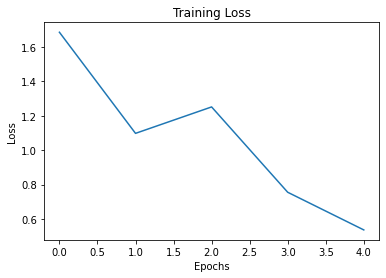

In [16]:
import matplotlib.pyplot as plt

plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_lst)
plt.show()

## Evaluate the model

In [17]:
test_loader = DataLoader(dataset = TwitterDataset(overallTest, preProcessDataFrame),
                            batch_size = 1,
                            shuffle = True)
model.eval()
loss_lst_1 = []
# cumLoss = 0
for (i, (X, y)) in enumerate(test_loader):
  X = torch.squeeze(X).cuda()
  y = y.T.cuda()
  y_hat = model(X)
  y_log = torch.log(y+1)
  # cum_loss += loss_fn(scores, labels).item()
  loss = loss_function(y_hat, y_log)
  loss_lst_1.append(loss.cpu().data.numpy())
  # cumLoss += loss

# print(f"MSELoss: {cumLoss / len(test_loader)}")
print(f"MSELoss: {loss}")
print(f"Average MSELoss: {sum(loss_lst_1)/len(loss_lst_1)}")

plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_lst_1)
plt.show()

MSELoss: 0.7454245090484619
Average MSELoss: 0.7538457370986623


In [18]:
from datetime import datetime

now = datetime.now()

d4 = now.strftime("%Y%m%d_%H%M%S")
print(d4)

PATH = "model_{0}.pt".format(d4) #change this name to the name of your network

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

20210807_162451


In [39]:
# print(type(loss_lst))
pd.DataFrame(loss_lst).to_csv("model_loss_graph/train_loss_" + PATH +"_1" + '.csv')
pd.DataFrame(loss_lst_1).to_csv("model_loss_graph/test_loss_" + PATH +"_1"  + '.csv')

model_20210804_144105.pt ->
MSELoss: 0.9546071290969849
Average MSELoss: 0.9292153011668812

model_20210804_175014.pt ->
MSELoss: 0.8757791519165039
Average MSELoss: 0.7937239170074463

 17%|█▋        | 1/6 [06:41<33:29, 401.85s/it]

Epoch: 0, Loss: 1.1006280183792114, 


 33%|███▎      | 2/6 [14:12<28:42, 430.51s/it]

Epoch: 1, Loss: 1.1077030897140503, 


 50%|█████     | 3/6 [20:08<19:49, 396.58s/it]

Epoch: 2, Loss: 0.8206214904785156, 


 67%|██████▋   | 4/6 [25:55<12:33, 376.88s/it]

Epoch: 3, Loss: 0.6652104258537292, 


 83%|████████▎ | 5/6 [31:50<06:09, 369.15s/it]

Epoch: 4, Loss: 0.7284358143806458, 


100%|██████████| 6/6 [37:45<00:00, 377.58s/it]

Epoch: 5, Loss: 0.6629458665847778, 


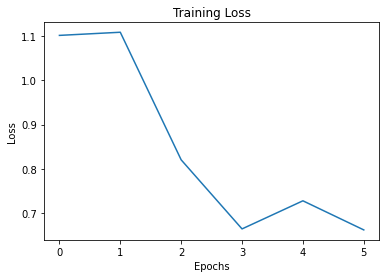

MSELoss: 1.3725109100341797
Average MSELoss: 1.3734898858819127


In [22]:
numEpochs = 6
lr_rate = 1e-3
input_size = 18

model = myNeuralNetwork(input_size)

loss_function = nn.MSELoss()

if using_GPU:
  model = model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)

loss_lst2 = []

for i in tqdm(range(numEpochs)):
  for X, y in train_loader:

    X = torch.squeeze(X).cuda()
    y = y.T.cuda()

    optimizer.zero_grad() 
    y_hat = model(X)
    y_log = torch.log(y+1)
    loss = loss_function(y_hat, y_log) #calculate the loss
    loss.backward() #backprop
    optimizer.step() #does the update
    
  loss_lst2.append(loss.cpu().data.numpy())
  if i % 1 == 0:
      print ("Epoch: {0}, Loss: {1}, ".format(i, loss.cpu().data.numpy()))

plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_lst2)
plt.show()

test_loader = DataLoader(dataset = TwitterDataset(overallTest, preProcessDataFrame),
                            batch_size = 1,
                            shuffle = True)
model.eval()
loss_lst_2 = []
for (i, (X, y)) in enumerate(test_loader):
  X = torch.squeeze(X).cuda()
  y = y.T.cuda()
  y_hat = model(X)
  y_log = torch.log(y+1)
  loss = loss_function(y_hat, y_log)
  loss_lst_2.append(loss.cpu().data.numpy())
print(f"MSELoss: {loss}")
print(f"Average MSELoss: {sum(loss_lst_2)/len(loss_lst_2)}")

plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_lst_2)
plt.show()

# Save your model

In [23]:
from datetime import datetime

now = datetime.now()

d4 = now.strftime("%Y%m%d_%H%M%S")
print(d4)

PATH = "model_{0}.pt".format(d4) #change this name to the name of your network

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

20210807_171152


In [40]:
pd.DataFrame(loss_lst2).to_csv("model_loss_graph/train_loss_" + PATH +"_2" + '.csv')
pd.DataFrame(loss_lst_2).to_csv("model_loss_graph/test_loss_" + PATH +"_2"  + '.csv')

# Load model from elsewhere
Just a reminder of how to load the model elsewhere after u save it. Also for me to deploy into the UI after you're done

In [24]:
# PATH = 

# # init empty model
# model = NeuralNetwork()
# optimModel = optim.SGD(modelA.parameters(), lr=0.001, momentum=0.9)

# # load checkpoint from saved path
# checkpoint = torch.load(PATH)

# # load model
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # model.eval()
# # - or -
# model.train()